# Effects of Iterations on Reconstruction Algorithms

In [76]:
import cv2
import time
import tomopy 
import matplotlib.pyplot as plt
import matplotlib.gridspec import Gridspec
import numpy as np
import dxchange as dx
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from array import *
rec = dict()

Below is the image that will showcase the differing effects of various algorithms on image reconstruction.

(1, 128, 128)


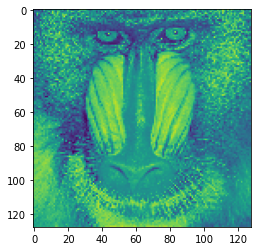

In [77]:
obj = tomopy.baboon(size=128)
print(obj.shape)
plt.figure()
plt.imshow(obj[0])
plt.show()

For this particular image, we are choosing to use 128 angled scans, ranging from 0 degrees to 180.

In [78]:
ang = tomopy.angles(nang=128, ang1=0, ang2=180)


In [79]:
prj = tomopy.project(obj, ang, pad=True)

Below is the simulated sinogram, which will be used to reconstruct the original image.

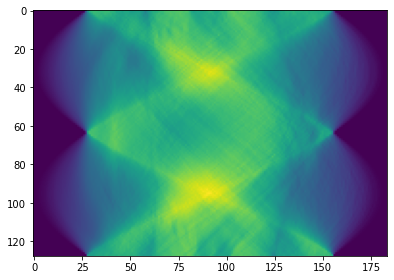

In [80]:
plt.figure(tight_layout=True)
plt.imshow(prj[:, 0, :])
plt.show()

Here we add poisson noise defects to the image in order to simulate experimental imperfections. 

In [81]:
prj_poisson = tomopy.add_poisson(prj/10)*100



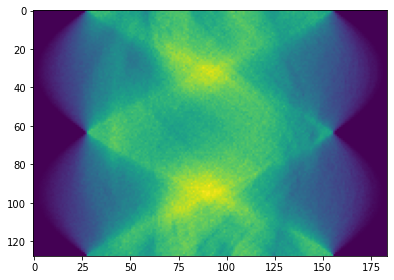

In [82]:
plt.figure(tight_layout=True)
plt.imshow(prj_poisson[:, 0, :])
plt.show()

Once again, we add rings to the sinogram to simulate defects. 

In [83]:
def add_rings(tomo, std=0.005):
    new_tomo = np.copy(tomo)
    sensitivity = np.random.normal(loc=1, scale=std, size=(1, new_tomo.shape[1], new_tomo.shape[2]))
    new_tomo = new_tomo * sensitivity
    return new_tomo


In [84]:
prj_both = add_rings(prj_poisson)

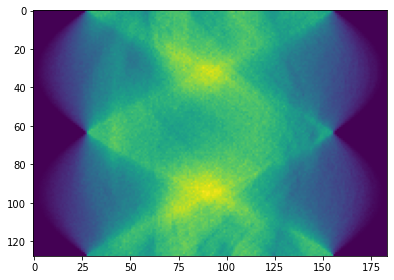

In [85]:
plt.figure(tight_layout=True)
plt.imshow(prj_both[:, 0, :])
plt.show()

Here we create a dictionary which contains two arrays, both of which contain iteration dependent data values. iter_imgs contains image reconstructions via the use of one the reconstruction algorithms. iter_time contains the time it takes to run each of these algorithms at various iteration lengths. This function also uses range and step values to determine how the iterations will be taken. For instance, one could go until 20 iterations, taking a sample image at each iteration length or at only every third iteration length.

In [86]:
def dis (algorithm, rng, stp):
    """Takes an algorithm, range, and step value, returns iterations at the step value in the given ranged.
       
        This function creates a directory which contains two arrays, one which contains the image recosntruction at each iteration, 
        and one which contains the time it takes to run each iteration.
        
        ----------------------------------------------------------
        Variables:
        iter_info: Directory of both arrays
        iter_imgs: Array of images
        iter_time: Array of time
        tic & toc: Before and after time 
        """
    iter_info = dict();
    iter_imgs = []
    iter_time = []
    if algorithm != 'ospml_hybrid2':
        for x in range(1,rng+1,stp):
            if x == 1:
                tic = time.perf_counter()
                current_img = tomopy.recon(prj_both, ang, num_gridx=128, algorithm = algorithm, num_gridy=128, num_iter= 1)
                toc = time.perf_counter()
                iter_imgs.append(current_img.copy())
                iter_time.append(toc-tic)
            else:
                tic = time.perf_counter()
                current_img = tomopy.recon(prj_both, ang, init_recon = iter_imgs[-1], num_gridx=128, algorithm = algorithm, num_gridy=128, num_iter= stp)
                toc = time.perf_counter()
                iter_imgs.append(current_img.copy())
                iter_time.append(toc-tic+iter_time[-1])
    else:
        for x in range(1,rng+1,stp):
            if x == 1:
                tic = time.perf_counter()
                current_img = tomopy.recon(prj_both, ang, algorithm = 'ospml_hybrid', num_gridx = 128, num_gridy=128, num_iter=1, reg_par = [.1, .1], num_block=10)
                toc = time.perf_counter()
                iter_imgs.append(current_img.copy())
                iter_time.append(toc-tic)
            else:
                tic = time.perf_counter()
                current_img = tomopy.recon(prj_both, ang, init_recon = iter_imgs[-1], algorithm = 'ospml_hybrid', num_gridx = 128, num_gridy=128, num_iter=1, reg_par = [.1, .1], num_block=10)
                toc = time.perf_counter()
                iter_imgs.append(current_img.copy())
                iter_time.append(toc-tic + iter_time[-1])
    iter_info['time'] = iter_time
    iter_info['iterations'] = iter_imgs
    return iter_info

In [87]:
rec['art'] = dis('art', 20, 1)
rec['mlem']= dis('mlem', 20, 1)
rec['ospml_hybrid'] = dis('ospml_hybrid', 20, 1)

Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstruc

Here we display the images in a one-to-one display, which shows the relative effectiveness of each at different iteration lengths.

(1, 128, 128)


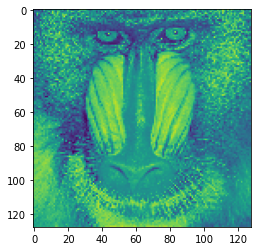

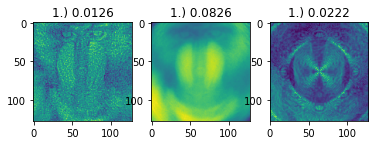

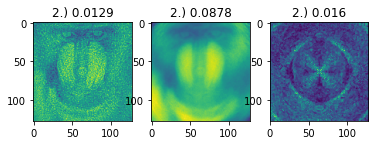

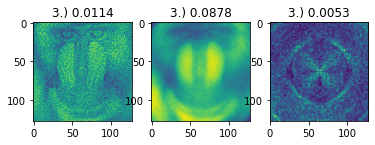

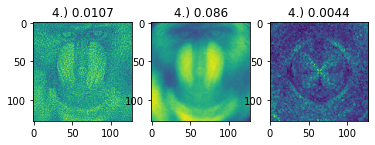

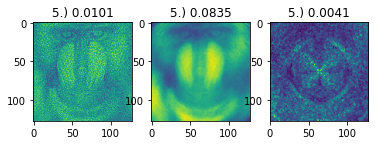

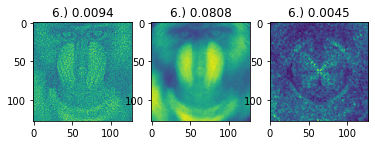

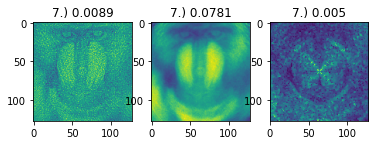

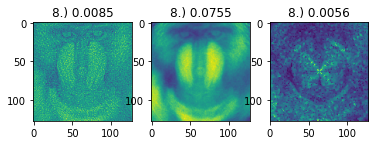

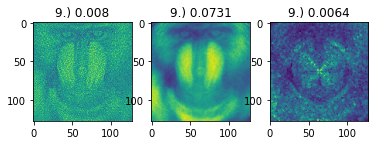

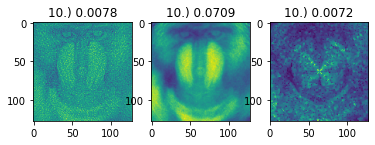

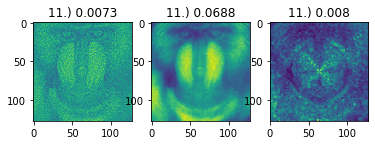

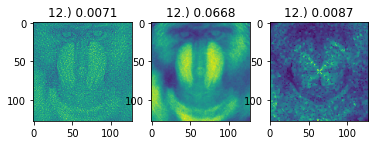

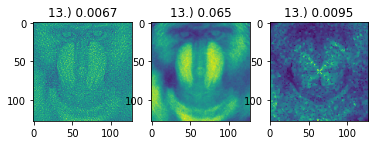

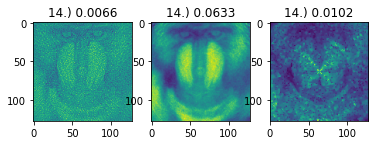

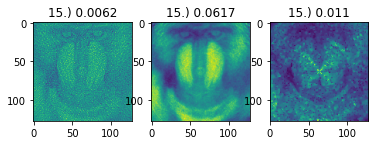

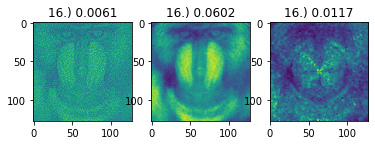

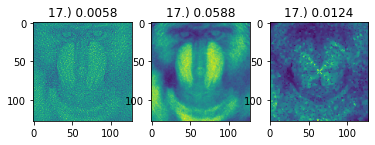

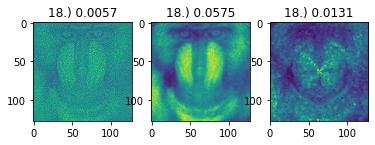

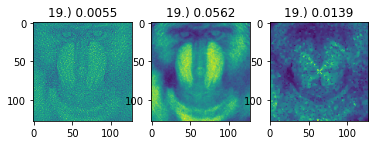

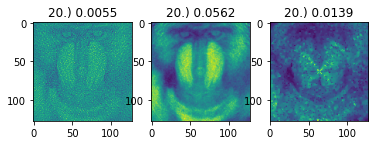

In [88]:
art_array = []
mlem_array = []
ospml_hybrid_array = []
print(obj.shape)
plt.figure()
plt.imshow(obj[0])
plt.show()
for x in range(0,60):
    if x%3==0:
        plt.figure(figsize=(6,2))
        plt.subplot(131+x%3)
        plt.imshow(rec['art']['iterations'][int(x/3)][0])
        title = str(round(int(x/3)+1,4))
        title += '.) '
        title += str(round(ssim(obj[0], rec['art']['iterations'][int(x/3)][0]),4))
        plt.title(title)
        art_array.append(ssim(obj[0], rec['art']['iterations'][int(x/3)][0]))


    if x%3==1:
        plt.subplot(131+x%3)
        plt.imshow(rec['mlem']['iterations'][int(((x-x%3)/3))][0])
        title = str(round(int(((x-x%3)/3)+1),4))
        title+= '.) '
        title += str(round(ssim(obj[0], rec['mlem']['iterations'][int(((x-x%3)/3))][0]),4))
        plt.title(title)
        mlem_array.append(ssim(obj[0], rec['mlem']['iterations'][int(((x-x%3)/3))][0]))


    if x%3==2:
        plt.subplot(131+x%3)
        plt.imshow(rec['ospml_hybrid']['iterations'][int(((x-x%3)/3))][0])
        title = str(round(int((x-x%3)/3)+1,4))
        title += '.) '
        title += str(round(ssim(obj[0], rec['ospml_hybrid']['iterations'][int(((x-x%3)/3))][0]),4))
        plt.title(title)
        ospml_hybrid_array.append(ssim(obj[0], rec['ospml_hybrid']['iterations'][int(((x-x%3)/3))][0]))




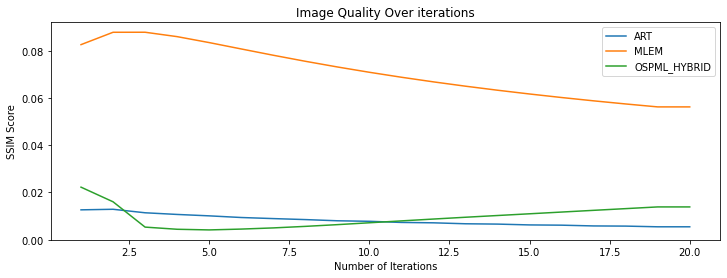

In [89]:
X=[]
for x in range(0, 20):
    X.append(x+1)
    
plt.figure(figsize=(12,4))
plt.xlabel('Number of Iterations')
plt.ylabel('SSIM Score')
plt.title('Image Quality Over iterations')
plt.plot(X, art_array, label= 'ART')
plt.plot(X, mlem_array, label= 'MLEM')
plt.plot(X, ospml_hybrid_array, label= 'OSPML_HYBRID')
plt.legend()
plt.show()



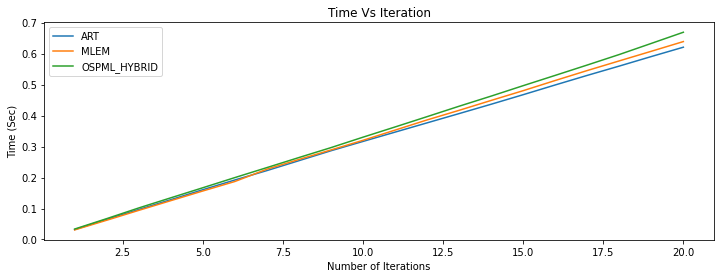

In [90]:
X=[]
for x in range(0,20):
    X.append(x+1)
plt.figure(figsize=(12,4))
plt.xlabel('Number of Iterations')
plt.ylabel('Time (Sec)')
plt.title('Time Vs Iteration')
plt.plot(X, rec['art']['time'], label= 'ART')
plt.plot(X, rec['mlem']['time'], label = 'MLEM' )
plt.plot(X, rec['ospml_hybrid']['time'], label = 'OSPML_HYBRID')
plt.legend()
plt.show()




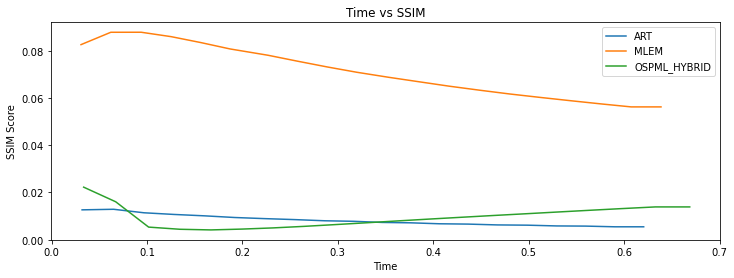

In [91]:
X=[]
for x in range(0,50):
    X.append(x+1)

plt.figure(figsize=(12,4))
plt.xlabel('Time')
plt.ylabel('SSIM Score')
plt.title('Time vs SSIM')
plt.plot(rec['art']['time'], art_array, label= 'ART')
plt.plot(rec['mlem']['time'], mlem_array, label= 'MLEM')
plt.plot( rec['ospml_hybrid']['time'], ospml_hybrid_array, label= 'OSPML_HYBRID')
plt.legend()
plt.show()

From looking at the data, it is clear that the MLEM algorithm far outperforms the other two. It peaks at 2 iterations at an image quality of .088 (on the SSIM index, the ideal is 1 with a range over (-1,1)). OSPML_HYBRID is the next best, with an initial high which quickly dips, and then slowly increases with more and more iterations. The ART algorithm is the worst, starting at a low quality and only decreasing from there. However, art does perform at a faster speed, which seems to become a more pronounced difference as iteration length increases.

Here we test to see what the effects of higher iterations over the OSPML_HYBRID will have, since from the data it looks as if the algorithm may outperform MLEM at higher iteration lengths.

In [92]:
rec['ospml_hybrid2']= dis('ospml_hybrid', 400, 16)

Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstruc

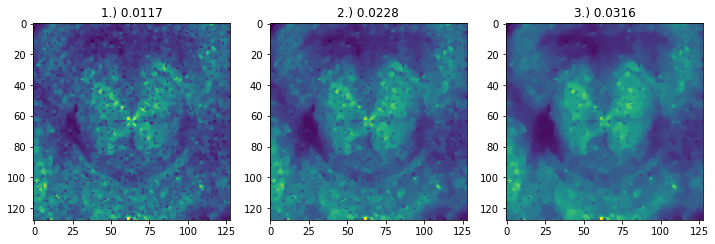

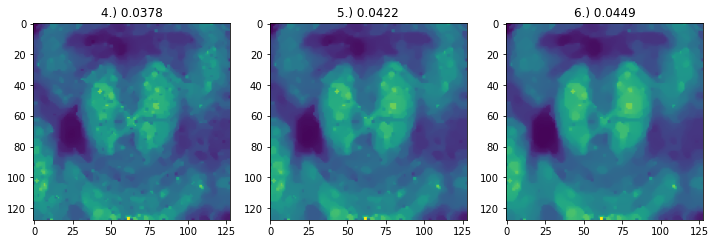

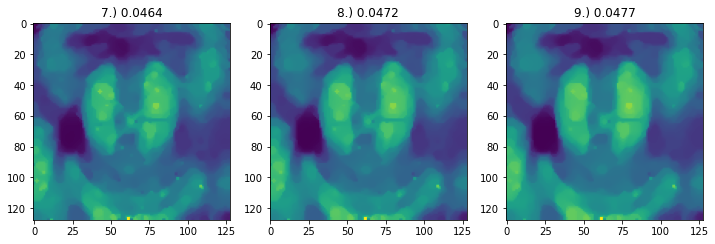

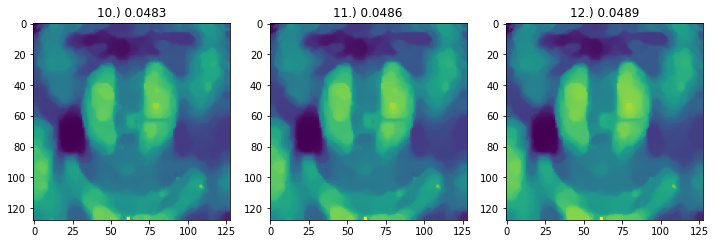

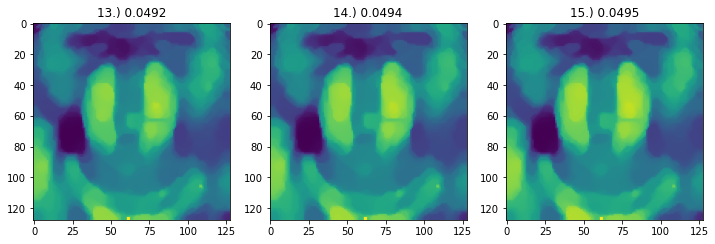

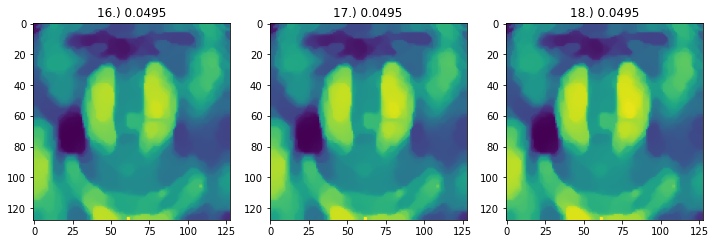

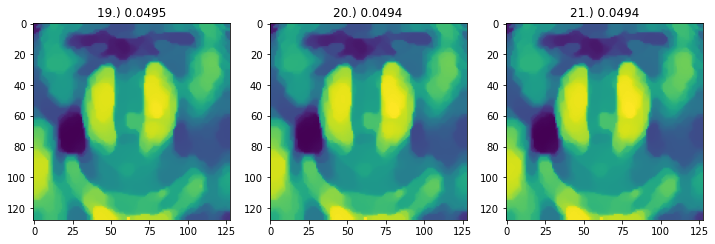

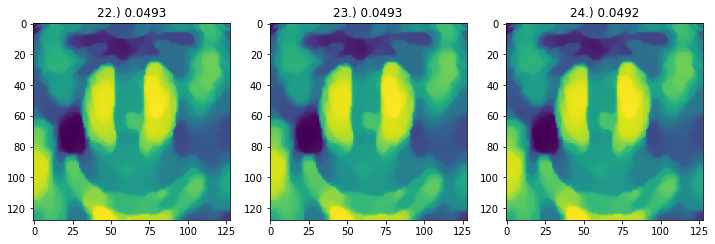

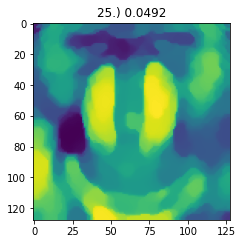

In [93]:
ospml_hybrid_array2=[]
for x in range(0,25):
    if x%3==0:
        plt.figure(figsize=(12,4))
    plt.subplot(131+x%3)
    plt.imshow(rec['ospml_hybrid2']['iterations'][x][0])
    title = str(x+1)
    title += '.) '
    title += str(round(ssim(obj[0], rec['ospml_hybrid2']['iterations'][x][0]),4))
    plt.title(title)
    ospml_hybrid_array2.append(ssim(obj[0], rec['ospml_hybrid2']['iterations'][x][0]))





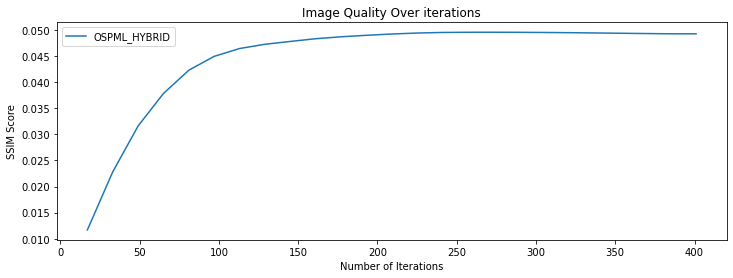

In [94]:
X=[]
for x in range(1,400,16):
    X.append(x+16)
    
plt.figure(figsize=(12,4))
plt.xlabel('Number of Iterations')
plt.ylabel('SSIM Score')
plt.title('Image Quality Over iterations')
plt.plot(X, ospml_hybrid_array2 , label= 'OSPML_HYBRID')
plt.legend()
plt.show()


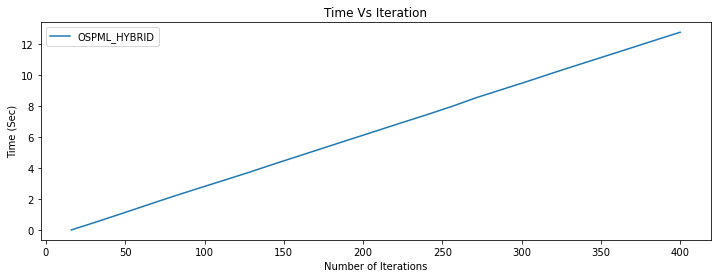

In [95]:
X=[]
for x in range(0,400,16):
    X.append(x+16)
plt.figure(figsize=(12,4))
plt.xlabel('Number of Iterations')
plt.ylabel('Time (Sec)')
plt.title('Time Vs Iteration')
plt.plot(X, rec['ospml_hybrid2']['time'], label = 'OSPML_HYBRID')
plt.legend()
plt.show()

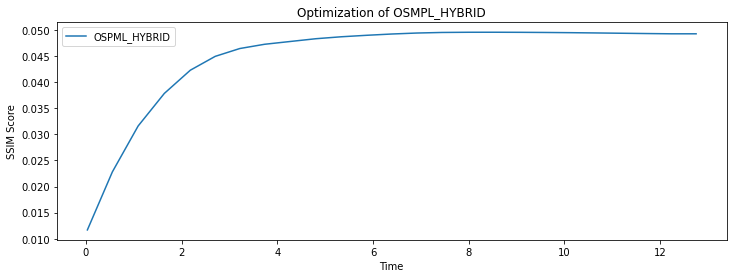

In [96]:
X=[]
for x in range(0,400,16):
    X.append(x+16)
plt.figure(figsize=(12,4))
plt.xlabel('Time')
plt.ylabel('SSIM Score')
plt.title('Optimization of OSMPL_HYBRID')
plt.plot(rec['ospml_hybrid2']['time'], ospml_hybrid_array2  , label = 'OSPML_HYBRID')
plt.legend()
plt.show()

As you can see, the OSPML_HYBRID seems to hit a max value of almost .05 and then slowly decreases. Although the reconstructed images take on a plastic look which lacks many of the fine details, the error score remains somewhat high, which reflects the structural importance that the SSIM metric uses. However, despite this improvement, the OSPML_HYBRID never tops the max of the MLEM method, the method taking much longer to achieve worse results as well.

# Findings: 

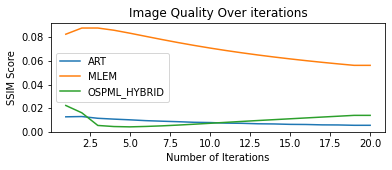

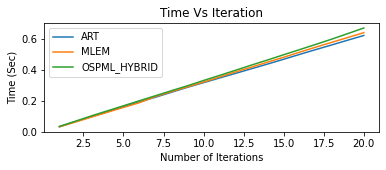

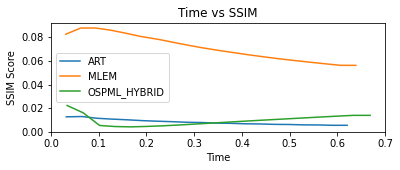

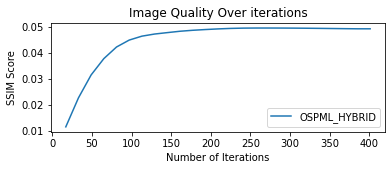

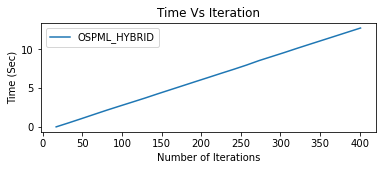

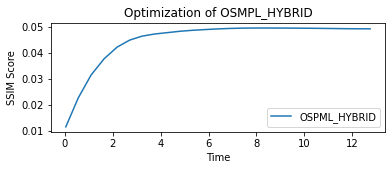

In [111]:
X=[]
for x in range(0, 20):
    X.append(x+1)
    
plt.figure(figsize=(6,2))
plt.xlabel('Number of Iterations')
plt.ylabel('SSIM Score')
plt.title('Image Quality Over iterations')
plt.plot(X, art_array, label= 'ART')
plt.plot(X, mlem_array, label= 'MLEM')
plt.plot(X, ospml_hybrid_array, label= 'OSPML_HYBRID')
plt.legend()
plt.show()

plt.figure(figsize=(6,2))
plt.xlabel('Number of Iterations')
plt.ylabel('Time (Sec)')
plt.title('Time Vs Iteration')
plt.plot(X, rec['art']['time'], label= 'ART')
plt.plot(X, rec['mlem']['time'], label = 'MLEM' )
plt.plot(X, rec['ospml_hybrid']['time'], label = 'OSPML_HYBRID')
plt.legend()
plt.show()

plt.figure(figsize=(6,2))
plt.xlabel('Time')
plt.ylabel('SSIM Score')
plt.title('Time vs SSIM')
plt.plot(rec['art']['time'], art_array, label= 'ART')
plt.plot(rec['mlem']['time'], mlem_array, label= 'MLEM')
plt.plot( rec['ospml_hybrid']['time'], ospml_hybrid_array, label= 'OSPML_HYBRID')
plt.legend()
plt.show()

Y=[]
for x in range(1,400,16):
    Y.append(x+16)
    
plt.figure(figsize=(6,2))
plt.xlabel('Number of Iterations')
plt.ylabel('SSIM Score')
plt.title('Image Quality Over iterations')
plt.plot(Y, ospml_hybrid_array2 , label= 'OSPML_HYBRID')
plt.legend()
plt.show()

plt.figure(figsize=(6,2))
plt.xlabel('Number of Iterations')
plt.ylabel('Time (Sec)')
plt.title('Time Vs Iteration')
plt.plot(Y, rec['ospml_hybrid2']['time'], label = 'OSPML_HYBRID')
plt.legend()
plt.show()

plt.figure(figsize=(6,2))
plt.xlabel('Time')
plt.ylabel('SSIM Score')
plt.title('Optimization of OSMPL_HYBRID')
plt.plot(rec['ospml_hybrid2']['time'], ospml_hybrid_array2  , label = 'OSPML_HYBRID')
plt.legend()
plt.show()

We have found that of the three algorithms working on defective image data which contains poisson noise and rings, MLEM performs the best of the three with regards to image quality, with OSPML_HYBRID as the next best at higher iterations and ART the worst overall. When it comes to efficiency, ART performs the best, OSPML_HYBRID the worst, and MLEM somewhere in the middle. However, this difference in time only becomes significant as the number of iterations increases, and so for problems which require a moderate to low amount of iterations, MLEM works best in terms of both efficiency and image quality.  

At first OSPML_HYBRID seemed to have the potential to eventually pass MLEM in terms of image quality at higher iterations, but upon testing it was found that OSPML_HYBRID reaches a max of about .05 and then starts to slowly decrease from there.
